# Inputs and simulation

[![Binder](https://static.mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/dm4bem_book/HEAD?labpath=%2Ftutorials%2Fpd05simulation.ipynb)

This notebook, which uses [dm4bem](dm4bem.py) module, shows a complete example of simulation for a toy model obtained by assembling. It covers (Figure 1):
    
- Model:
    - given data on walls (type and data on surfaces), thermal circuits and the assembling lists or matrix;
    - obtain the matrices and vectors of the thermal circuit $A, G, C, b, f, y$:
        - convert a folder containing the files characterizing the building into
    a disassambled thermal circuit (function `dm4bem.bldg2TCd()`);
        - assemble the thermal circuits (functions `dm4bem.assemble_TCd_matrix()` and `db4bem.assemble_lists2matrix()`);
    - transform the thermal circuit into state-space representation $A_s, B_s, C_s, D_s, u_s$ (function `dm4bem.tc2ss()`).


- Inputs:
    - given the [Typical Meteorological Years (TMY)](https://en.m.wikipedia.org/wiki/Typical_meteorological_year) in EnergyPlus format `.epw`; 
    - read weather data: outdoor temperature $T_o$, direct solar radiation $E_{dir}$ and diffuse solar radiation $E_{diff}$ (functions `dm4bem.read_epw()`) and calculate the solar radiation on tilted surfaces (function `dm4bem.sol_rad_tilt_surf()`);
    - determine the weather sources:
        - outdoor temperarure $T_o$,
        - solar radiation absorbed by the outdoor wall $\Phi_o$, the indoor wall $\Phi_o$, and the glass $\Phi_a$.  
    - define the scheduled inputs, such as indoor temperature set points $T_{i,sp}$ and auxiliary flow-rates $\dot Q_a$;


- Simulation:
    - prepare the inputs from input description of the state-space, $u_s$, and the _input data set_ (function `dm4bem.inputs_in_time()`);
    - integrate in time by using Euler explicit and/or implicit methods.

The complete example may be downloaded or run on mybinder from [GitHub](https://github.com/cghiaus/dm4bem_toy_model?tab=readme-ov-file).

![work_flow](./pd/bldg/work_flow.svg)

> Figure 1. Workflow for building simulation by using `dm4bem` module. The `dm4bem` functions are in bold letters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dm4bem

## Model
### Thermal circuits
Consider the disassembled thermal circuits shown in Figure 1 that we want to assemble as shown in Figure 2 and then obtain the state-space representation. The model is described in Jupyter Notebook on [Toy model house](02_2_1Toy.ipynb).

![disassambled_TC](./pd/bldg/ass_TCd.svg)
> Figure 1. Four disassembled thermal circuits: [TC0](./pd/bldg/TC0.csv), [TC1](./pd/bldg/TC1.csv), [TC2](./pd/bldg/TC2.csv), [TC3](./pd/bldg/TC3.csv), and [wall_out](./pd/bldg/walls_out.csv) (which is based on [wall_types](./pd/bldg/wall_types.csv)). 

![disassambled_TC](./pd/bldg/ass_TC.svg)
> Figure 2. Assembling the four circuits from Figure 1 according to the [assembly matrix](./pd/bldg/assembly_matrix.csv) or to the [asssembly lists](./pd/bldg/assembly_lists.csv). The dashed black arrows show the merging of nodes, e.g., node 5 of circuit ow0 (faded, because it dissapears) is merged with node 0 of circuit c2 (which is kept).

The thermal circuits are described in a folder (see section _Description of the folder containing the circuits_ in Jupyter Notebook on [Disassembled thermal circuits from folder describing the building](pd02bldg2TCd.ipynb)).

### State-space representation
The steps to obtain a state-space model from disassembled thermal circuits are:
1. Obtain the disassambled set of thermal circuits from data given in a folder ([link](https://github.com/cghiaus/dm4bem_book/tree/main/tutorials/pd/bldg)).
2. Assemble the set of thermal circuits.
3. Transform the thermal circuit into state-space representation.

In [2]:
# Disassembled thermal circuits
folder_bldg = './pd/bldg'
TCd = dm4bem.bldg2TCd(folder_bldg,
                      TC_auto_number=True)

# Assembled thermal circuit
ass_lists = pd.read_csv(folder_bldg + '/assembly_lists.csv')
ass_matrix = dm4bem.assemble_lists2matrix(ass_lists)
TC = dm4bem.assemble_TCd_matrix(TCd, ass_matrix)

We can change the values of the conductances and the capacities from the thermal circuit.

In [3]:
# TC['G']['c3_q0'] = 1e3  # Kp, controler gain
# TC['C']['c2_θ0'] = 0    # indoor air heat capacity
# TC['C']['c1_θ0'] = 0    # glass (window) heat capacity

The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) is obtained from the [thermal circuit](./pd/bldg/ass_TC.svg) (described by the matrices $A$, $G$, $C$ and the vectors $b$, $f$, and $y$).

In [4]:
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
us

c1_q0        To
c2_q0        To
c3_q0     Ti_sp
ow0_q0       To
c1_θ0        Φa
c2_θ0        Qa
ow0_θ0       Φo
ow0_θ4       Φi
dtype: object

In [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) `[As, Bs, Cs, Ds, us]`:

- `As`: state (or system) matrix;
- `Bs`: input matrix;
- `Cs`: output matrix;
- `Ds`: feedthrough (or feedforward) matrix;
- `us` : correspondence between:
    - the branches (e.g. `c1_q0` for circuit _c1_ branch _q0_) and the symbol of the temperature source (e.g. `To`, see [thermal circuit](./pd/bldg/ass_TC.svg));
    - the nodes (e.g. `c1_θ0` for circuit _c1_ node _θ0_) and the symbol of flow-rate source (e.g. `Φa`, see [thermal circuit](./pd/bldg/ass_TC.svg)).

### Time step and settling time
The eigenvalues analysis of the state matrix yields:

- maximum __time step__ for Euler explicit method: $\Delta t_{max} = 2·\mathrm{min} (-1 / \lambda_i)$, where $\lambda$ is the vector of eigenvalues of the state matrix $A_s$ and $T_i = -1 / \lambda_i$ are the time constants;
- minimum __settling time__: $t_{settle} = 4 \ \mathrm{max} (-1 / \lambda_i$). 

In [5]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

In [6]:
dt_max = 2 * min(-1. / λ)    # max time step for Euler explicit stability
print(f'dt_max = {dt_max:.1f} s')
dt = dm4bem.round_time(dt_max)
dm4bem.print_rounded_time('dt', dt)

dt_max = 498.6 s
dt = 300 s = 5.0 min


In [7]:
t_settle = 4 * max(-1. / λ)
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

duration = 176400 s = 49.0 h


## Inputs for step response

The [step response](https://en.m.wikipedia.org/wiki/Step_response) consists of the time response of the system when one or more inputs change instantaneously at time $t = 0$. The _input data set_ of the system contains the temperature ($T_o$, $T_{i,sp}$) and flow-rate ($\Phi_o$, $\Phi_i$, $\Phi_a$, $\dot{Q}_a$) sources.

The input vector in time, $u$, may have repeated values; in our [thermal circuit](./pd/bldg/ass_TC.svg), the outdoor temperature source $T_o$ is on three branches: $c_1 \_q_0$, $c_2\_q_0$ and $ow_0\_q_0$.

The input vector in time, $u$, is a DataFrame with time as index (note that the year is __2000__ by convention); its columns are the values of the inputs arranged in the order given by the vector $u_s$ (obtained in the state-space representation from the sources indicated by symbols in vectors $b$ and $f$ of the thermal circuit). The transformation from _input data set_ to the _input vector in time_ is done by the function `inputs_in_time()` from `dm4bem` module.

In [8]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                     periods=n, freq=f"{int(dt)}S")

To = 10 * np.ones(n)
Ti_sp = 20 * np.ones(n)
Φa = 0 * np.ones(n)
Qa = Φo = Φi = Φa

# key <- symbol in b and f of thermal circuit TC
# value <- time series of the source
data = {'To': To, 'Ti_sp': Ti_sp, 'Qa': Qa, 'Φo': Φo, 'Φi': Φi, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)
input_data_set

,To,Ti_sp,Qa,Φo,Φi,Φa
2000-01-01 00:00:00,10.0,20.0,0.0,0.0,0.0,0.0
2000-01-01 00:05:00,10.0,20.0,0.0,0.0,0.0,0.0
2000-01-01 00:10:00,10.0,20.0,0.0,0.0,0.0,0.0
2000-01-01 00:15:00,10.0,20.0,0.0,0.0,0.0,0.0
2000-01-01 00:20:00,10.0,20.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2000-01-03 00:35:00,10.0,20.0,0.0,0.0,0.0,0.0
2000-01-03 00:40:00,10.0,20.0,0.0,0.0,0.0,0.0
2000-01-03 00:45:00,10.0,20.0,0.0,0.0,0.0,0.0
2000-01-03 00:50:00,10.0,20.0,0.0,0.0,0.0,0.0


Note that `input_data_set` containts the time series of the inputs specified by symbols in the vectors $b$ and $f$ of the thermal circuit. The names of the columns the keys of `data`, which need to correpond to the symbols indicated in vectors $b$ and $f$ of the thermal circuit. The values of `data` are time series given by the variables of the respective keys.

The input vector in time `u` is obtained from correspondece between branches / nodes and temeperature / flow sources given in `us` and the time series given in `input_data_set`.

In [9]:
# Get input u from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
u

,c1_q0,c2_q0,c3_q0,ow0_q0,c1_θ0,c2_θ0,ow0_θ0,ow0_θ4
2000-01-01 00:00:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:05:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:10:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:15:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:20:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2000-01-03 00:35:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-03 00:40:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-03 00:45:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-03 00:50:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0


Note the the columns of `u`are the names of the branches and of the nodes from the [thermal circuit](./pd/bldg/ass_TC.svg).

## Simulation

### Step response

#### Initial conditions

In [10]:
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0                      # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

#### Time integration

The formula for [Euler](https://en.m.wikipedia.org/wiki/Euler_method)  integration is:

$$ \theta_{k+1} = (I + \Delta t A_s) \theta _k + \Delta t B_s u_k $$

for forward (or explicit) and:

$$\theta_{k+1} = (I - \Delta t A_s)^{-1}(\theta_k + \Delta t B_s u_{k + 1})$$

for backward (or implicit) integration.

In [11]:
I = np.eye(As.shape[0])     # identity matrix

for k in range(n - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k + 1])

#### Output values

Once the state variables, i.e. the temperatures in nodes that have capacities $\theta_C$, are found, the temperatures in the other nodes are:

$$y = C_s \theta + D_s u$$

In [12]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

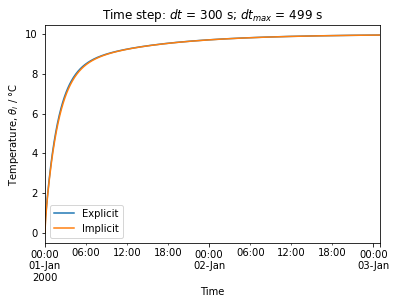

In [13]:
# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)
y.plot()
plt.xlabel('Time')
plt.ylabel('Temperature, $θ_i$ / °C')
plt.title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {dt_max:.0f} s')
plt.show()

> Figure 3. Step response by using Euler explicit and Euler implicit integration methods.

### Simulation with weather data

#### Start and end date-time
The simulation will be done from `date_start` to `date_end` indicated in the format `MM-DD HH:MM:SS` (month-day hour:minute:second).

In [14]:
date_start = '02-01 12:00:00'
date_end = '02-07 18:00:00'

The weather data are for a year. The choice of `2000` for the year is arbitrary; it used in order to respect the format `YYYY-MM-DD HH:MM:SS`.

In [15]:
date_start = '2000-' + date_start
date_end = '2000-' + date_end
print(f'{date_start} \tstart date')
print(f'{date_end} \tend date')

2000-02-01 12:00:00 	start date
2000-02-07 18:00:00 	end date


#### Input data set
##### Weather data
Dynamic simulation needs [time series](https://en.m.wikipedia.org/wiki/Time_series) of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on [weather data and solar radiation](01WeatherData.ipynb) and weather file [FRA_Lyon.074810_IWEC.epw](../weather_data/FRA_Lyon.074810_IWEC.epw)).

In [16]:
file_weather = '../weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(file_weather, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m²,

The yearly weather data set is from different years. By convenction, we set the year at `2000`. Then, we select the data from start date to end date and resample the weather data to the time step used in simulation.

In [17]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[date_start:date_end]

##### Temperature sources

The set of temperature sources contains:
- $T_o$ - outdor temperature;
- $T_{i, sp}$ - indoor temperature set-point.

For indoor temperature set-point $T_{i, sp}$ let's consider day time (from 6:00 to 22:00) and night time (the rest of the day) values.

In [18]:
# Temperature sources
To = weather['temp_air']

Ti_day, Ti_night = 20, 16
Ti_sp = pd.Series(20, index=To.index)
Ti_sp = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    index=To.index)

##### Flow-rate sources 

__Total solar irradiance on the outdoor wall__

For the surface orientation of the outdoor wall, given by `slope`, `azimuth`and `latitude`, and the `albedo` of the surface in front of the wall, by using the weather data, we can calculate the direct, diffuse irradiance, and reflected irradiance solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance), in W/m², on a tilted surface. The total irradiance, $E_{tot}$, is the sum of direct, diffuse and reflected irradiances.

In [19]:
# total solar irradiance
wall_out = pd.read_csv(folder_bldg + '/walls_out.csv')
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])

Etot = rad_surf.sum(axis=1)

__Flow-rate sources__

$\Phi_o$: solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:

- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\Phi_i$: short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

$\Phi_a$: short wave (i.e. solar) radiation, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\dot{Q}_a$: auxiliary heat flows (from occupants, electrical devices, etc.), in W.

In [20]:
# Window glass properties
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass
S_g = 9         # m2, surface area of glass

# Flow-rate sources
# solar radiation
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot
Φa = α_gSW * S_g * Etot

# auxiliary (internal) sources
Qa = pd.Series(0, index=To.index)

##### Input data set

In [21]:
# Input data set
input_data_set = pd.DataFrame({'To': To, 'Ti_sp': Ti_sp,
                               'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa,
                               'Etot': Etot})

#### Time integration

##### Input vector

Time integration requires the input vector $u$ which is obtained from the _input data set_ (i.e., sources), arranged according to the order given by $u_s$ from the state-space representation.

In [22]:
# Resample hourly data to time step dt
input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')

# Get input from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

##### Initial conditions

In [23]:
# initial conditions
θ0 = 20                      # initial temperatures
θ_exp = pd.DataFrame(index=u.index)
θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0

##### Numerical integration
[Explicit Euler](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [24]:
# time integration
I = np.eye(As.shape[0])     # identity matrix

for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]

started from initial conditions, yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

and the variation of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [25]:
# outputs
y = (Cs @ θ_exp.T + Ds @  u.T).T

Kp = TC['G']['c3_q0']     # W/K, controller gain
S = 3 * 3                 # m², surface area of the toy house
q_HVAC = Kp * (u['c3_q0'] - y['c2_θ0']) / S  # W/m²

In order to plot the results, from the data let's select the outdoor temperature $T_o$, the indoor temoerature $\theta_i$, the total solar irradiance $E_{tot}$, and the specific thermal load $q_{HVAC}$.

##### Results

In [26]:
data = pd.DataFrame({'To': input_data_set['To'],
                     'θi': y['c2_θ0'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

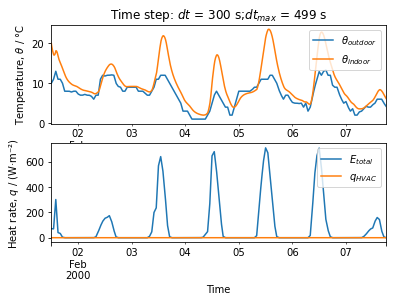

Min. indoor temperature: 2.0 °C
Max. indoor temperature: 23.5 °C
Max. load: 0.0 W at 2000-02-01 12:00:00+01:00
Energy consumption: 0.0 kWh


In [27]:
fig, axs = plt.subplots(2, 1)
data[['To', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
axs[0].set_title(f'Time step: $dt$ = {dt:.0f} s;'
                 f'$dt_{{max}}$ = {dt_max:.0f} s')
plt.show()

print(f'Min. indoor temperature: {data["θi"].min():.1f} °C')
print(f'Max. indoor temperature: {data["θi"].max():.1f} °C')

max_load = data['q_HVAC'].max()
max_load_index = data['q_HVAC'].idxmax()
print(f"Max. load: {max_load:.1f} W at {max_load_index}")
print(f"Energy consumption: {(data['q_HVAC'] * dt).sum() / (3.6e6):.1f} kWh")

> Figure 4. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

<a id='script'></a>
## Pyhton script

The script [pd/pd05simulation.py](pd/pd05simulation.py) implements the __workflow__ presented in this notebook. In order to run this script (in the [environment](../environment.yml)):

1. Create a working directory, e.g. `pd`

2. Download [dm4bem](dm4bem.py) module and save it the working directory.

3. Create subfolder `/bldg` in the working directory.

4. Download [TC0](./pd/bldg/TC0.csv), [TC1](./pd/bldg/TC1.csv), [TC2](./pd/bldg/TC2.csv), [TC3](./pd/bldg/TC3.csv), and [wall_out](./pd/bldg/walls_out.csv) (of [wall_types](./pd/bldg/wall_types.csv)), and [asssembly lists](./pd/bldg/assembly_lists.csv) files and save them in subfolder `/bldg`.

4. Create subfolder `/weather_data`.

5. Download weather file [FRA_Lyon.074810_IWEC.epw](./pd/weather_data/FRA_Lyon.074810_IWEC.epw) and save it in subfolder `/weather_data`.

6. Run the script.

The files may be downloaded or run on mybinder from [GitHub](https://github.com/cghiaus/dm4bem_toy_model?tab=readme-ov-file).

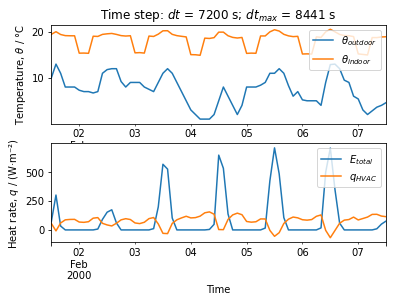

In [29]:
%%capture --no-display
%cd pd
%run pd05simulation.py
%cd -

> Figure 5. Results of script `pd05simulation.py`.

## Discussion

See the _Discussion_ section of notebook on [Toy model house / Steady-state and step response](02_2_2Toy.ipynb).

__Free-floating or P-controller__

After the assembling of the thermal circuit with the function `dm4bem.assemble_TCd_matrix`, change the gain of the P-controller by setting the value of `TC['G']['c3_q0']`:
- $K_p = 0$: no controller (i.e., free-floating);
- $K_p = 10^3$: good balance between precision and time-step;
- $K_p = 10^2$: the time step is larger by the precision is low;
- $K_p = 10^4$: the precision is good but the time step is very small.


__Negligible small capacities__

After the assembling of the thermal circuit with the function `dm4bem.assemble_TCd_matrix`, set the indoor air capacity to zero, `TC['C']['c2_θ0'] = 0` and the glass capacity to zero, `TC['C']['c1_θ0'] = 0` one-by-one and both in the same time. Note the time step and the precision of the controller in each case.

## References

1. [C. Ghiaus (2013)](https://doi.org/10.1016/j.energy.2012.10.024). Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, , open access preprint: [HAL-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. [C. Ghiaus (2021)](https://doi.org/10.1007/978-3-030-76477-7_5). Dynamic Models for Energy Control of Smart Homes, in *S. Ploix M. Amayri, N. Bouguila (eds.) Towards Energy Smart Homes*, Online ISBN: 978-3-030-76477-7, Print ISBN: 978-3-030-76476-0, Springer, pp. 163-198, open access preprint: [HAL 03578578](https://hal.archives-ouvertes.fr/hal-03578578/document)

3. [J.A. Duffie, W. A. Beckman, N. Blair (2020)](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf). Solar Engineering of Thermal Processes, 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

4. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html). Annexe à l’arrêté du 19 juillet 2006

5. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

6. [J.R. Howell et al. (2021)](http://www.thermalradiation.net/indexCat.html). Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, A Catalogue of Configuration Factors

7. [J. Widén, J. Munkhammar (2019)](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf). Solar Radiation Theory, Uppsala University